<a href="https://colab.research.google.com/github/mitsuogui/Face-Recognition-Proyect-Talller/blob/main/I_Etapa_FR_face_recognition_estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [ ]:
!pip install face_recognition         # Install face_recognition package using pip



import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output


# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# Importar la librería datetime para poder manejar fechas
import datetime

import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=3384a0b353fd569a0eed11d5b604d6ad1e3a4fe9ae7af9aee420c7faa4e5d813
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


# Utils

## In-memory data

In [ ]:
registered_faces = {}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## face recognition

In [ ]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [ ]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [ ]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Recognize Faces

<IPython.core.display.Javascript object>

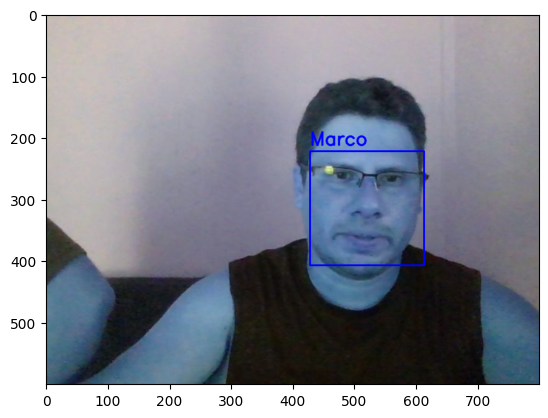

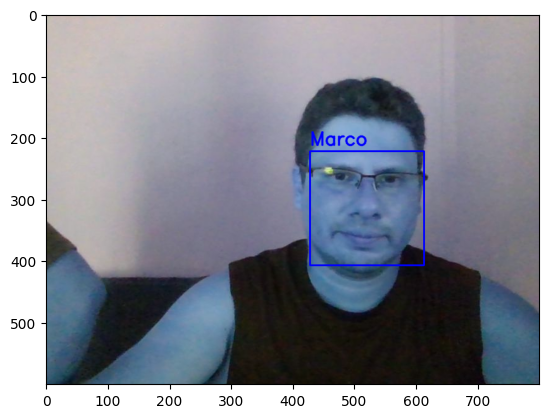

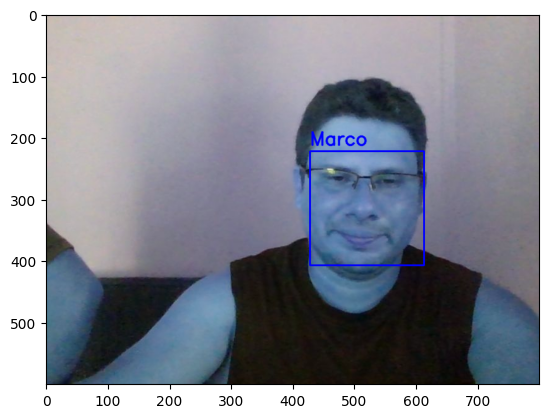

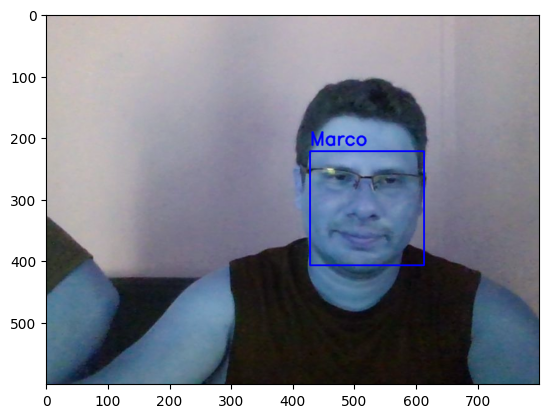

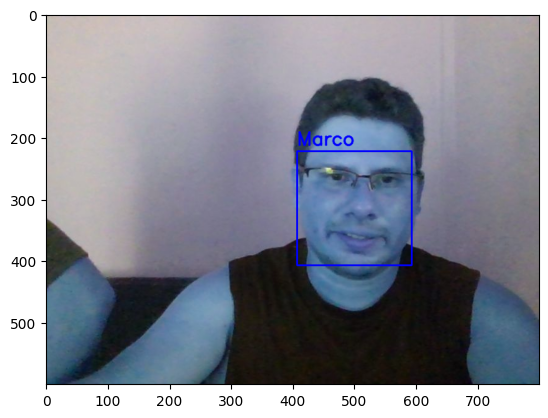

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
          # Get the index of the match
          match_index = matches.index(True)

          # Get the name of the match
          match_name = list(registered_faces.keys())[match_index]

          # Draw the name of the match on the frame
          cv2.putText(
              frame,
              match_name,
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )
      else:
          # Draw unknown on the frame
          cv2.putText(
              frame,
              "Unknown",
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )

  # Show image
  plt.imshow(frame)
  plt.show()

In [ ]:
#CLASE 8
print(match_name)

Cris


# Professors list

In [ ]:

# Define a function to obtain the professor's information
def add_professor():
    # Request Id
    id = input("Enter Id: ")

    # Request Name
    name = input("Enter professor`s name: ")
    # Ask if the name is in registered face's list

    if name not in registered_faces:
      print("Professor's face not found in registered faces database.")
      return None


    # Request birthday
    birthday = input("Enter the birthday (mm/dd/yyyy): ")

    # Request Nationality
    nationality = input("Enter Nationality: ")

    # Request phone numbers
    phone_numbers = []
    print("Enter phone numbers, one per line. To finish, press Enter on an empty line")
    while True:
        enter_phone_numbers = input("Enter phone number, one per line. To finish, press Enter on an empty line: ")
        if enter_phone_numbers == "":
            break
        phone_numbers.append(enter_phone_numbers)

    # Request emails
    emails = []
    print("Enter emails, one per line. To finish, press Enter on an empty line.")
    while True:
        email = input("Enter email: ")
        if email == "":
            break
        emails.append(email)

    # Request home direction
    address = input("Enter home address: ")

    # Request speciality
    speciality = input("Enter speciality: ")

    # Request years in institution
    years_in_institution = int(input("Enter years in institution: "))

    # Request personal vehicle license plate
    vehicle_license_plate = input("Enter your personal vehicle license plate (N/A if the professor do not have a vehicle): ")


    # Create a dictionary with the professor's information
    prof_info = {
        "identification": id,
        "name": name,
        "birthday": datetime.datetime.strptime(birthday, "%m/%d/%Y").date(),
        "nationality": nationality,
        "phone numbers": phone_numbers,
        "emails": emails,
        "home address": address,
        "speciality": speciality,
        "years in the institution": years_in_institution,
        "personal vehicle license plate": vehicle_license_plate
    }

    # Return the dictionary with the professor's information
    return prof_info

# Generate the list of professors
prof_list = []

# Request professors information
while True:
    # Get information from a professor
    prof_info = add_professor()

    # Add professor information to the professor list
    prof_list.append(prof_info)

    # Ask if the user want's to add another professor
    option = input("Do you want to add another professor? (y/n): ")
    if option != "y":
        break

# Imprimir la lista de profesores
for prof_info in prof_list:
    print(prof_info)


Enter Id: 1
Enter professor`s name: Tony
Enter the birthday (mm/dd/yyyy): 11/02/1989
Enter Nationality: usa
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish, press Enter on an empty line: 
Enter emails, one per line. To finish, press Enter on an empty line.
Enter email: tonyq
Enter email: 
Enter home address: usa norte
Enter speciality: meca
Enter years in institution: 9
Enter your personal vehicle license plate (N/A if the professor do not have a vehicle): c8877
Do you want to add another professor? (y/n): y
Enter Id: Cris
Enter professor`s name: Cris
Enter the birthday (mm/dd/yyyy): 11/01/1990
Enter Nationality: usa
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish, press Enter on an empty line: 7778889
Enter phone number, one per line. To finish, press Enter on an empty line: 
Enter emails, one per line. To finish, press Enter on an empty line.
E

In [ ]:
print(type(prof_list))
print(type(prof_info))
print(prof_list)

<class 'list'>
<class 'dict'>
[{'identification': '1', 'name': 'Tony', 'birthday': datetime.date(1989, 11, 2), 'nationality': 'usa', 'phone numbers': [], 'emails': ['tonyq'], 'home address': 'usa norte', 'speciality': 'meca', 'years in the institution': 9, 'personal vehicle license plate': 'c8877'}, {'identification': 'Cris', 'name': 'Cris', 'birthday': datetime.date(1990, 11, 1), 'nationality': 'usa', 'phone numbers': ['7778889'], 'emails': ['crisq'], 'home address': 'usa norte', 'speciality': 'civil', 'years in the institution': 1, 'personal vehicle license plate': '888888'}]


In [ ]:
def consult_prof(lista):
    for profesor in lista:
        if profesor==None:
          print("")
        else:
          print("Profesor Information:")
          for key, value in profesor.items():
              if key == 'birthday':
                  print(f"{key}: {value.strftime('%m/%d/%Y')}")
              elif key == 'phone numbers':
                  print(f"{key}:")
                  for phone in value:
                      print(f"  - {phone}")
              elif key == 'emails':
                  print(f"{key}:")
                  for email in value:
                      print(f"  - {email}")
              else:
                  print(f"{key}: {value}")
          print()  # Imprime una línea en blanco entre cada profesor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_prof(prof_list)


Profesor Information:
identification: 1
name: Tony
birthday: 11/02/1989
nationality: usa
phone numbers:
emails:
  - tonyq
home address: usa norte
speciality: meca
years in the institution: 9
personal vehicle license plate: c8877

Profesor Information:
identification: Cris
name: Cris
birthday: 11/01/1990
nationality: usa
phone numbers:
  - 7778889
emails:
  - crisq
home address: usa norte
speciality: civil
years in the institution: 1
personal vehicle license plate: 888888



# Students list

In [ ]:

# Define a function to add student information
def add_student():
    # Request Identification
    identification = input("Enter Identification: ")

    # Request Name
    name = input("Enter student`s name: ")
    # Ask if the name is in registered face's list

    if name not in registered_faces:
      print("Student's face not found in registered faces database.")
      return None


    # Request birthday
    birthday = input("Enter the birthday (mm/dd/yyyy): ")

    # Request Nationality
    nationality = input("Enter Nationality: ")

    # Request phone numbers
    phone_numbers = []
    print("Enter phone numbers, one per line. To finish, press Enter on an empty line")
    while True:
        enter_phone_numbers = input("Enter phone number, one per line. To finish, press Enter on an empty line: ")
        if enter_phone_numbers == "":
            break
        phone_numbers.append(enter_phone_numbers)

    # Request emails
    emails = []
    print("Enter emails, one per line. To finish, press Enter on an empty line.")
    while True:
        email = input("Enter email: ")
        if email == "":
            break
        emails.append(email)

    # Request home direction
    address = input("Enter home address: ")

    # Request years in institution
    degree= input("Enter the degree that you're studying : ")

    # Request scholarchip
    scholarchip = input("Enter your scholarchip, if you don't have put 0")


    # Create a dictionary with the professor's information
    student_info = {
        "identification": identification,
        "name": name,
        "birthday": datetime.datetime.strptime(birthday, "%m/%d/%Y").date(),
        "nationality": nationality,
        "phone numbers": phone_numbers,
        "emails": emails,
        "home address": address,
        "degree": degree,
        "scholarchip": scholarchip,
    }

    # Return the dictionary with the student's information
    return student_info

# Generate the list of students
student_list = []

# Request students information
while True:
    # Get information from a students
    student_info = add_student()

    # Add professor information to the students list
    student_list.append(student_info)

    # Ask if the user want's to add another students
    option = input("Do you want to add another student? (y/n): ")
    if option != "y":
        break

# Imprimir la lista de students
for student_info in student_list:
    print(student_info)

Enter Identification: 1111
Enter student`s name: Marco
Enter the birthday (mm/dd/yyyy): 11/02/1989
Enter Nationality: costa
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish, press Enter on an empty line: 55555
Enter phone number, one per line. To finish, press Enter on an empty line: 
Enter emails, one per line. To finish, press Enter on an empty line.
Enter email: marcoqc
Enter email: 
Enter home address: valle
Enter the degree that you're studying : compu
Enter your scholarchip, if you don't have put 010
Do you want to add another student? (y/n): n
{'identification': '1111', 'name': 'Marco', 'birthday': datetime.date(1989, 11, 2), 'nationality': 'costa', 'phone numbers': ['55555'], 'emails': ['marcoqc'], 'home address': 'valle', 'degree': 'compu', 'scholarchip': '10'}


In [ ]:
#función consulta estudiante
def consult_student(lista):
    for student in lista:
        if student==None:
          print("")
        else:
          print("Students Information:")
          for key, value in student.items():
              if key == 'birthday':
                  print(f"{key}: {value.strftime('%m/%d/%Y')}")
              elif key == 'phone numbers':
                  print(f"{key}:")
                  for phone in value:
                      print(f"  - {phone}")
              elif key == 'emails':
                  print(f"{key}:")
                  for email in value:
                      print(f"  - {email}")
              else:
                  print(f"{key}: {value}")
          print()  # Imprime una línea en blanco entre cada profesor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_student(student_list)


Students Information:
identification: 1111
name: Marco
birthday: 11/02/1989
nationality: costa
phone numbers:
  - 55555
emails:
  - marcoqc
home address: valle
degree: compu
scholarchip: 10



# Miscellaneous list

In [ ]:

# Define a function to get the miscellaneous information
def add_miscellaneous():
    # Request Identification
    identification = input("Enter Identification: ")

    # Request Name
    name = input("Enter miscellaneous`s name: ")
    # Ask if the name is in registered face's list

    if name not in registered_faces:
      print("Miscellaneous's face not found in registered faces database.")
      return None

   # Ask for the date of birth
    date_of_birth = input("Enter the date of birth (mm/dd/yyyy): ")

    # Ask for the nationality
    nationality = input("Enter the nationality: ")

    # Ask for the phone numbers
    phone_numbers = []
    print("Enter the phone numbers, one per line. To finish, press Enter on an empty line.")
    while True:
        phone_number = input("Enter a phone number: ")
        if phone_number == "":
            break
        phone_numbers.append(phone_number)

    # Ask for the emails
    emails = []
    print("Enter the emails, one per line. To finish, press Enter on an empty line.")
    while True:
        email = input("Enter an email: ")
        if email == "":
            break
        emails.append(email)

    # Ask for the address
    address = input("Enter the address: ")

    # Ask for the shift
    shift = input("Enter the shift: ")

    # Ask for the gross salary in colones
    gross_salary = float(input("Enter the gross salary in colones: "))

    # Ask for the work sector
    work_sector = input("Enter the work sector: ")

    # Create a dictionary with the miscellaneous information
    miscellaneous_information = {
        "id": id,
        "name": name,
        "date_of_birth": datetime.datetime.strptime(date_of_birth, "%m/%d/%Y").date(),
        "nationality": nationality,
        "phone_numbers": phone_numbers,
        "emails": emails,
        "address": address,
        "shift": shift,
        "gross_salary": gross_salary,
        "work_sector": work_sector
    }

    # Return the dictionary with the miscellaneous information
    return miscellaneous_information



# Initialize the miscellaneous list
miscellaneous_list = []

for miscellaneous_information in miscellaneous_list:
    print(miscellaneous_information)

# Request the miscellaneous information
while True:
    # Get the information of a misceláneo
    miscellaneous_information = add_miscellaneous()

    # Add the information of the misceláneo to the list of misceláneos
    miscellaneous_list.append(miscellaneous_information)

    # Ask if you want to add another miscellaneous
    option = input("Do you want to add another miscellaneous? (y/n): ")
    if option != "y":
        break



Enter the id: 1111
Enter the name: Jolie
Enter the date of birth (mm/dd/yyyy): 12/01/1980
Enter the nationality: ingla
Enter the phone numbers, one per line. To finish, press Enter on an empty line.
Enter a phone number: 88888888
Enter a phone number: 
Enter the emails, one per line. To finish, press Enter on an empty line.
Enter an email: jolieq
Enter an email: 
Enter the address: ingla nor oeste
Enter the shift: 
Enter the gross salary in colones: 545000
Enter the work sector: aulas 100-110
Do you want to add another miscellaneous? (y/n): n
{'id': '1111', 'name': 'Jolie', 'date_of_birth': datetime.date(1980, 12, 1), 'nationality': 'ingla', 'phone_numbers': ['88888888'], 'emails': ['jolieq'], 'address': 'ingla nor oeste', 'shift': '', 'gross_salary': 545000.0, 'work_sector': 'aulas 100-110'}


In [ ]:
#función consulta miscellaneous
def consult_miscellaneous(lista):
    for miscellaneous in lista:
        if miscellaneous==None:
          print("")
        else:
          print("Miscellaneous Information:")
          for key, value in miscellaneous.items():
              if key == 'birthday':
                  print(f"{key}: {value.strftime('%m/%d/%Y')}")
              elif key == 'phone numbers':
                  print(f"{key}:")
                  for phone in value:
                      print(f"  - {phone}")
              elif key == 'emails':
                  print(f"{key}:")
                  for email in value:
                      print(f"  - {email}")
              else:
                  print(f"{key}: {value}")
          print()  # Imprime una línea en blanco entre cada profesor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_miscellaneous(miscellaneous_list)


Miscellaneous Information:
id: 1111
name: Jolie
date_of_birth: 1980-12-01
nationality: ingla
phone_numbers: ['88888888']
emails:
  - jolieq
address: ingla nor oeste
shift: 
gross_salary: 545000.0
work_sector: aulas 100-110



#Classroom information

In [ ]:

# Define a function to add classroom
def add_classroom():
    # Request numbre of classroom
    number = input("Enter number of classroom: ")

    # Request Name
    miscellaneous = input("Enter miscellaneou`s assigned: ")
    # Ask if the name is in registered miscellaneous list
    for miscellaneous_name in miscellaneous_list:
      name = miscellaneous_name.get('name')
      if miscellaneous not in registered_faces:
        print("Miscellaneous no assigned")
        return None


    # Request air conditioning
    air_conditioning_working = input("Enter if the air conditioning  is workin (Yes) or not (No): ")

    # Request scholarchip
    capacity = input("Enter the capacity of the classroom")


    # Create a dictionary with the professor's information
    classroom_info = {
        "number": number,
        "miscellaneous": miscellaneous,
        "air_conditioning_working": air_conditioning_working,
        "capacity": capacity,
    }

    # Return the dictionary with the student's information
    return classroom_info

# Generate the list of classroom
classroom_list = []

# Request classroom information
while True:
    # Get information from a classroom
    classroom_info = add_classroom()

    # Add classroom
    classroom_list.append(classroom_info)

    # Ask if the user want's to add another classroom
    option = input("Do you want to add another student? (y/n): ")
    if option != "y":
        break

# Imprimir clasrrom list
for classroom_info in classroom_list:
    print(classroom_info)

Enter number of classroom: a10
Enter miscellaneou`s assigned: Jolie
Enter if the air conditioning  is workin (Yes) or not (No): yes
Enter the capacity of the classroom25
Do you want to add another student? (y/n): n
{'number': 'a10', 'miscellaneous': 'Jolie', 'air_conditioning_working': 'yes', 'capacity': '25'}


In [ ]:
#func consult classrooms
def consult_classroom(lista):
  """
  """
  for classroom in lista:
      if classroom==None:
        print("")
      else:
        print("Classroom Information:")
        for key, value in classroom.items():
          print(f"{key}: {value}")
        print()  # Imprime una línea en blanco entre cada add_professor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_classroom(classroom_list)

Classroom Information:
number: a10
miscellaneous: Jolie
air_conditioning_working: yes
capacity: 25



# Course Information

In [ ]:
# Function to add course
def add_course():
    # get course information
    code = input("Enter the course code: ")
    name = input("Enter the course name: ")
    period = input("Entr period: ")
    career = input("Enter carerr the course belong to: ")

    # get students list in course
    student_names = input("Enter names of students in the course separed with comma: ").split(',')
    students = []
    for student_name in student_names:
        for student in student_list:
            if student_name.strip() == student['name']:
                students.append(student)
                break

    # get professor list
    professor_names = input("Enter the names of professors of the courses and separed with comma: ").split(',')
    professors = []
    for professor_name in professor_names:
        for professor in prof_list:
            if professor_name.strip() == professor['name']:
                professors.append(professor)
                break

    # get schedule
    schedule = input("Ingrese el horario (puede ser varios días): ")

    # get clasrroom
    classroom_numbers = input("Get the classroom's number (if are some separed with comma): ").split(',')
    classrooms = []
    for classroom_number in classroom_numbers:
        for classroom in classroom_dict:
            if classroom_number.strip() == classroom:
                classrooms.append(classroom)
                break

    # dic of course
    course_info = {
        "course_code": code,
        "course_name": name,
        "period": period,
        "career": career,
        "students": students,
        "professors": professors,
        "schedule": schedule,
        "classrooms": classrooms
    }

    return course_info

# List of courses
course_list = []

# Get information of courses
while True:
    course_info = add_course()
    course_list.append(course_info)
    another_course = input("¿Desea ingresar otro curso? (s/n): ")
    if another_course.lower() != 's':
        break

# Get list of courses
for course_info in course_list:
    print(course_info)

In [ ]:
def display_courses(course_list, student_list, prof_list):
    print("Información de los cursos:\n")
    for course in course_list:
        print(f"Código del curso: {course['course_code']}")
        print(f"Nombre del curso: {course['course_name']}")
        print(f"Período: {course['period']}")
        print(f"Carrera: {course['career']}")

        # Mostrar información de estudiantes matriculados
        print("\nEstudiantes matriculados:")
        for student in course['students']:
            print(f"Nombre: {student['name']}")
            print(f"Identificación: {student['identification']}")
            print(f"Cumpleaños: {student['birthday']}")
            print(f"Nacionalidad: {student['nationality']}")
            print(f"Números de teléfono: {', '.join(student['phone numbers'])}")
            print(f"Emails: {', '.join(student['emails'])}")
            print(f"Dirección: {student['home address']}")
            print(f"Grado: {student['degree']}")
            print(f"Beca: {student['scholarship']}")
            print()

        # Mostrar información de profesores
        print("\nProfesores del curso:")
        for professor in course['professors']:
            print(f"Nombre: {professor['name']}")
            print(f"Identificación: {professor['identification']}")
            print(f"Cumpleaños: {professor['birthday']}")
            print(f"Nacionalidad: {professor['nationality']}")
            print(f"Números de teléfono: {', '.join(professor['phone numbers'])}")
            print(f"Emails: {', '.join(professor['emails'])}")
            print(f"Dirección: {professor['home address']}")
            print(f"Especialidad: {professor['speciality']}")
            print(f"Años en la institución: {professor['years in the institution']}")
            print(f"Placa de vehículo personal: {professor['personal vehicle license plate']}")
            print()

        # Mostrar horario y aulas
        print(f"Horario: {course['schedule']}")
        print(f"Aulas: {', '.join(course['classrooms'])}")
        print("\n" + "=" * 40 + "\n")

# Llama a la función para mostrar la información de los cursos
display_courses(course_list, student_list, prof_list)


# Assistance

In [ ]:
attendance_list = []

def record_attendance(name, image_path):
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    attendance_entry = {
        'name': name,
        'image_path': image_path,
        'timestamp': timestamp
    }
    attendance_list.append(attendance_entry)

# Luego, cuando detectas una cara en el marco, puedes llamar a la función record_attendance para registrar la asistencia.


In [ ]:
# Dibujar un cuadro alrededor del rostro detectado
cv2.rectangle(
    frame,
    (left, top),
    (right, bottom),
    (0, 0, 255),
    2,
)

# Guardar la imagen con el cuadro
cv2.imwrite(image_path, frame)


In [ ]:
def display_attendance(attendance_list):
    for entry in attendance_list:
        print(f"Nombre: {entry['name']}")
        print(f"Fecha y hora: {entry['timestamp']}")
        print(f"Miniatura:")
        display(Image(filename=entry['image_path']))
        print("=" * 40)

# Consult student max assitance

In [ ]:
attendance_count = {}  # Diccionario para contar las asistencias

for entry in attendance_list:
    student_name = entry['name']
    if student_name in attendance_count:
        attendance_count[student_name] += 1
    else:
        attendance_count[student_name] = 1

most_attended_student = max(attendance_count, key=attendance_count.get)
most_attendances = attendance_count[most_attended_student]
print(f"Estudiante que asistió más veces: {most_attended_student} ({most_attendances} asistencias)")

# Consult student less assitance

In [ ]:
attendance_count = {}  # Diccionario para contar las asistencias

for entry in attendance_list:
    student_name = entry['name']
    if student_name in attendance_count:
        attendance_count[student_name] += 1
    else:
        attendance_count[student_name] = 1

least_attended_student = min(attendance_count, key=attendance_count.get)
least_attendances = attendance_count[least_attended_student]
print(f"Estudiante que asistió menos veces: {least_attended_student} ({least_attendances} asistencias)")

# Consult course the time with max assitance

In [ ]:
attendance_count_by_moment = {}  # Diccionario para contar asistencias por momento

for entry in attendance_list:
    moment = entry['moment']  # Debes asegurarte de que 'moment' sea una representación adecuada de la fecha y hora.
    if moment in attendance_count_by_moment:
        attendance_count_by_moment[moment].append(entry)
    else:
        attendance_count_by_moment[moment] = [entry]

most_attended_moment = max(attendance_count_by_moment, key=lambda x: len(attendance_count_by_moment[x]))

most_attended_people = attendance_count_by_moment[most_attended_moment]

print(f"Momento con más personas reportadas: {most_attended_moment} ({len(most_attended_people)} personas)")

# Mostrar la información de cada persona y su imagen con el nombre
for person_info in most_attended_people:
    print(f"Nombre: {person_info['name']}")
    # Aquí puedes mostrar la imagen con el cuadro que contiene el nombre de la persona
    display_image_with_name_box(person_info['image'], person_info['name'])

# Consult by course assitance

In [ ]:
course_name = input("Ingrese el nombre del curso: ")  # Solicitar el nombre del curso al usuario

# Filtrar la asistencia por el nombre del curso
attendance_for_course = [entry for entry in attendance_list if entry['course'] == course_name]

for entry in attendance_for_course:
    # Obtener la información de la persona a partir de su identificación
    person_info = get_person_info(entry['person_id'])

    # Mostrar la información de la persona
    print(f"Nombre: {person_info['name']}")
    print(f"Fecha y hora del reporte: {entry['moment']}")

    # Crear una imagen con un cuadro que tenga el nombre de la persona y mostrarla
    image_with_name_box = create_image_with_name_box(person_info['name'])
    display_image(image_with_name_box)

# Consult student's info by course

In [ ]:
student_info_list = []

for course in course_list:
    students_in_course = course['students']  # Obtener la lista de estudiantes matriculados en el curso
    student_info_list.extend(students_in_course)

complete_student_info_list = []

for student_id in student_info_list:
    student_info = get_student_info(student_id)  # Obtener la información completa del estudiante
    complete_student_info_list.append(student_info)

def insertion_sort_by_age(student_list):
    for i in range(1, len(student_list)):
        current_student = student_list[i]
        j = i - 1
        while j >= 0 and current_student['birthday'] > student_list[j]['birthday']:
            student_list[j + 1] = student_list[j]
            j -= 1
        student_list[j + 1] = current_student

insertion_sort_by_age(complete_student_info_list)  # Ordenar la lista de estudiantes por edad

for student_info in complete_student_info_list:
    print(f"Nombre: {student_info['name']}")
    print(f"Fecha de nacimiento: {student_info['birthday']}")
    print("-" * 20)  # Separador entre estudiantes

In [ ]:
# Obtener la información completa de los estudiantes en los cursos
student_info_list = []

for course in course_list:
    students_in_course = course['students']
    for student_id in students_in_course:
        for student in student_list:
            if student['identification'] == student_id:
                student_info_list.append(student)

# Función para ordenar la lista de estudiantes por edad usando el método de burbuja
def bubble_sort_by_age(student_list):
    n = len(student_list)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            # Convertir las fechas de cumpleaños en objetos datetime para compararlas
            birthday1 = datetime.strptime(student_list[j]['birthday'], '%Y-%m-%d')
            birthday2 = datetime.strptime(student_list[j + 1]['birthday'], '%Y-%m-%d')
            if birthday1 < birthday2:
                student_list[j], student_list[j + 1] = student_list[j + 1], student_list[j]

# Ordenar la lista de estudiantes por edad
bubble_sort_by_age(student_info_list)

# Mostrar la información ordenada de los estudiantes
for student_info in student_info_list:
    print(f"Nombre: {student_info['name']}")
    print(f"Fecha de nacimiento: {student_info['birthday']}")
    print("-" * 20)

# Requests

In [ ]:
# Function that print on screen the information requested by the user.
def requests():
  ask_for_request = input("Enter request: ")
  if ask_for_request==prof_info:
    print(prof_info)
  if ask_for_request==student_information:
    print(student_information)
  if ask_for_request==miscellaneous_information:
    print(miscellaneous_information)
  else:
    print("Invalid request")
  # Borrar después de leer: Después del tercer if, continue con el mismo formato para consultar por las otras listas.